<a href="https://colab.research.google.com/github/DOMINION-JOHN1/voting_eligibility_model/blob/main/preprocessing_of_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
# Define the file path of the np.array document
file_path = '/content/drive/My Drive/.npy'

# Load the np.array document using np.load()
loaded_array = np.load(file_path)

In [4]:
import tensorflow as tf

x=loaded_array


In [5]:
eligibility=pd.read_csv('/content/drive/My Drive/eligibility.csv')

In [6]:

eligibility['eligibility']=eligibility['eligibility'].replace('55', 'Eligible')
eligibility['eligibility']=eligibility['eligibility'].replace('35', 'Eligible')
eligibility['eligibility'] = eligibility['eligibility'].replace({'Eligible': 1, 'Not Eligible': 0})
target_label = np.array(eligibility['eligibility'])
target_label.astype('float32')
target_label.shape
y=target_label
y

array([1, 1, 1, ..., 1, 1, 1])

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Print the sizes of the train and test sets
print("Training data size:", len(X_train))
print("Testing data size:", len(X_test))

Training data size: 10850
Testing data size: 2713


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

# Convolutional Layer 2
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

# Convolutional Layer 3
model.add(Conv2D(128, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(128, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten the feature map
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0001), metrics=["accuracy"])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Define the file path for saving the best model
checkpoint_filepath = '/content/drive/My Drive/best_model.h5'

# Create callbacks
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=1e-6)

epochs = 1
batch_size = 15


# Fit the model with callbacks
hist = model.fit( datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // batch_size,
    callbacks=[checkpointer, early_stopping, reduce_lr],
    verbose=2
)



Epoch 1: val_loss improved from inf to 0.57580, saving model to /content/drive/My Drive/best_model.h5
723/723 - 1149s - loss: 0.7119 - accuracy: 0.6562 - val_loss: 0.5758 - val_accuracy: 0.7346 - lr: 0.0010 - 1149s/epoch - 2s/step


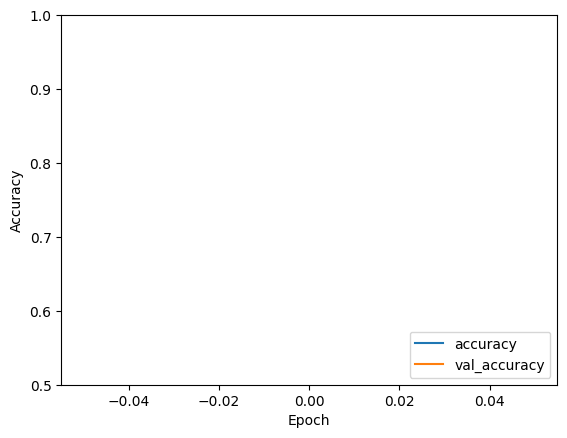

In [10]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [12]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss

In [11]:
class_dict = {
    0: 'Not Eligible',
    1: 'Eligible'
   }

In [13]:
def display_confusion_matrix(true_labels, predicted_labels, class_dict, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Visualizes the confusion matrix. Set `normalize=True` for normalization.
    """
    # Compute confusion matrix
    matrix = confusion_matrix(true_labels, predicted_labels)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8,6))
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)

    # Show color bar
    plt.colorbar()

    # Get class names from the dictionary
    class_names = list(class_dict.values())

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)

    # Text annotations inside the cells
    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in enumerate(matrix):
        for k, l in enumerate(j):
            plt.text(k, i, format(l, fmt),
                     ha="center", va="center",
                     color="white" if l > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()




In [17]:
# Plot confusion matrix for validation data

# Get model predictions
predictions = model.predict(X_test)
predicted_classes = [1 if p >= 0.5 else 0 for p in predictions]






85/85 [==============================] - 77s 913ms/step


In [19]:
predicted_class= np.array(predicted_classes)
predicted_class.astype('float32')
predicted_class

array([1, 1, 1, ..., 1, 1, 1])

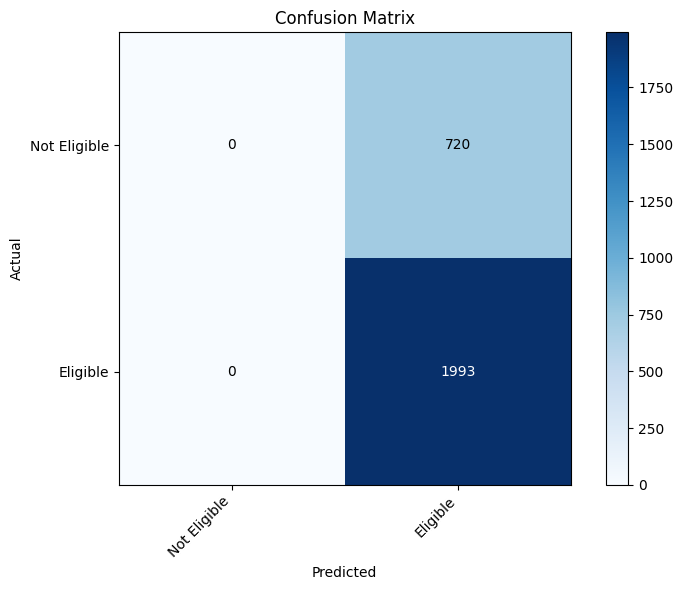

In [20]:
display_confusion_matrix(y_test,predicted_class,class_dict)

In [23]:
def compute_metrics(actual, predicted):
    """Compute precision, recall, F1-score, and specificity."""
    metrics = {}

    # 1. Precision
    metrics['Precision'] = precision_score(actual, predicted, average='weighted')

    # 2. Recall
    metrics['Recall'] = recall_score(actual, predicted, average='weighted')

    # 3. F1-Score
    metrics['F1 Score'] = f1_score(actual, predicted, average='weighted')

    # 4. Specificity (True Negative Rate)
    def compute_specificity(cm):
        """Compute specificity for each class, given a confusion matrix."""
        specificity_list = []
        for i in range(cm.shape[0]):
            tn = cm[~i, ~i].sum()
            fp = cm[~i, i].sum()
            specificity = tn / (tn + fp)
            specificity_list.append(specificity)
        return np.mean(specificity_list)

    confusion = confusion_matrix(actual, predicted)
    metrics['Specificity'] = compute_specificity(confusion)

    return metrics



# Compute metrics for validation data
val_predictions = predicted_class
val_actual = y_test
val_metrics = compute_metrics(val_actual, val_predictions)

# Convert metrics to dataframe
data = {
    'Validation': [val_metrics['Precision'], val_metrics['Recall'], val_metrics['F1 Score'], val_metrics['Specificity']]
}
df_metrics = pd.DataFrame(data, index=['Precision', 'Recall', 'F1 Score', 'Specificity'])

# Display the dataframe
df_metrics.head()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Validation
Precision,0.539654
Recall,0.734611
F1 Score,0.622218
Specificity,0.500000


85/85 [==============================] - 70s 818ms/step


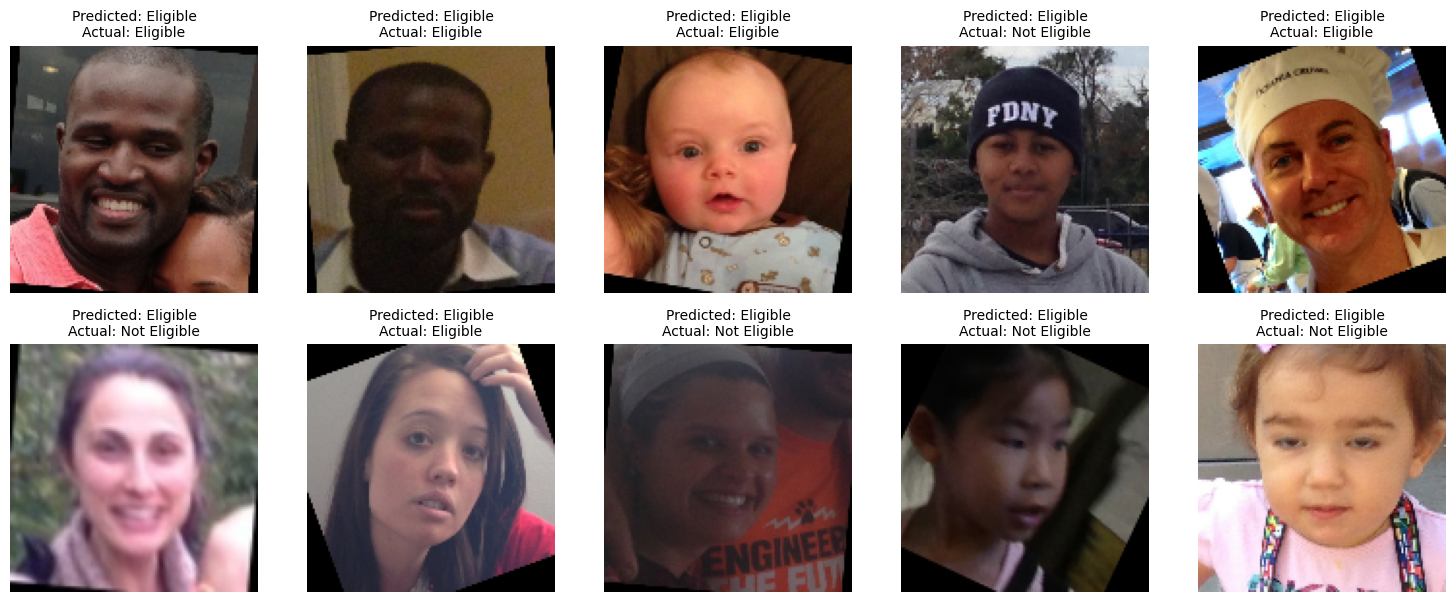

In [24]:
# Randomly select 50 indices
random_indices = np.random.choice(X_test.shape[0], 10, replace=False)
predictions = model.predict(X_test);

# Get the predicted and actual classes
predicted_classes = predicted_class
actual_classes = y_test

# Initialize a figure with a larger figsize
plt.figure(figsize=(15,30))

# Iterate over the random indices and plot the images
for i, idx in enumerate(random_indices):
    plt.subplot(10, 5, i+1)  # 10 rows and 5 columns

    # Use np.clip to make sure the image data is within the valid range
    img_data = np.clip(X_test[idx], 0, 1)
    plt.imshow(img_data)

    # Get the actual and predicted classes for this image
    actual_label = class_dict[actual_classes[idx]]
    predicted_label = class_dict[predicted_classes[idx]]

    # Set the title to "Predicted: [Predicted Label]\nActual: [Actual Label]"
    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
